
# Big Data Computing 2024 - Homework 1 - Deadline: November 28$^{th}$, 11.59pm

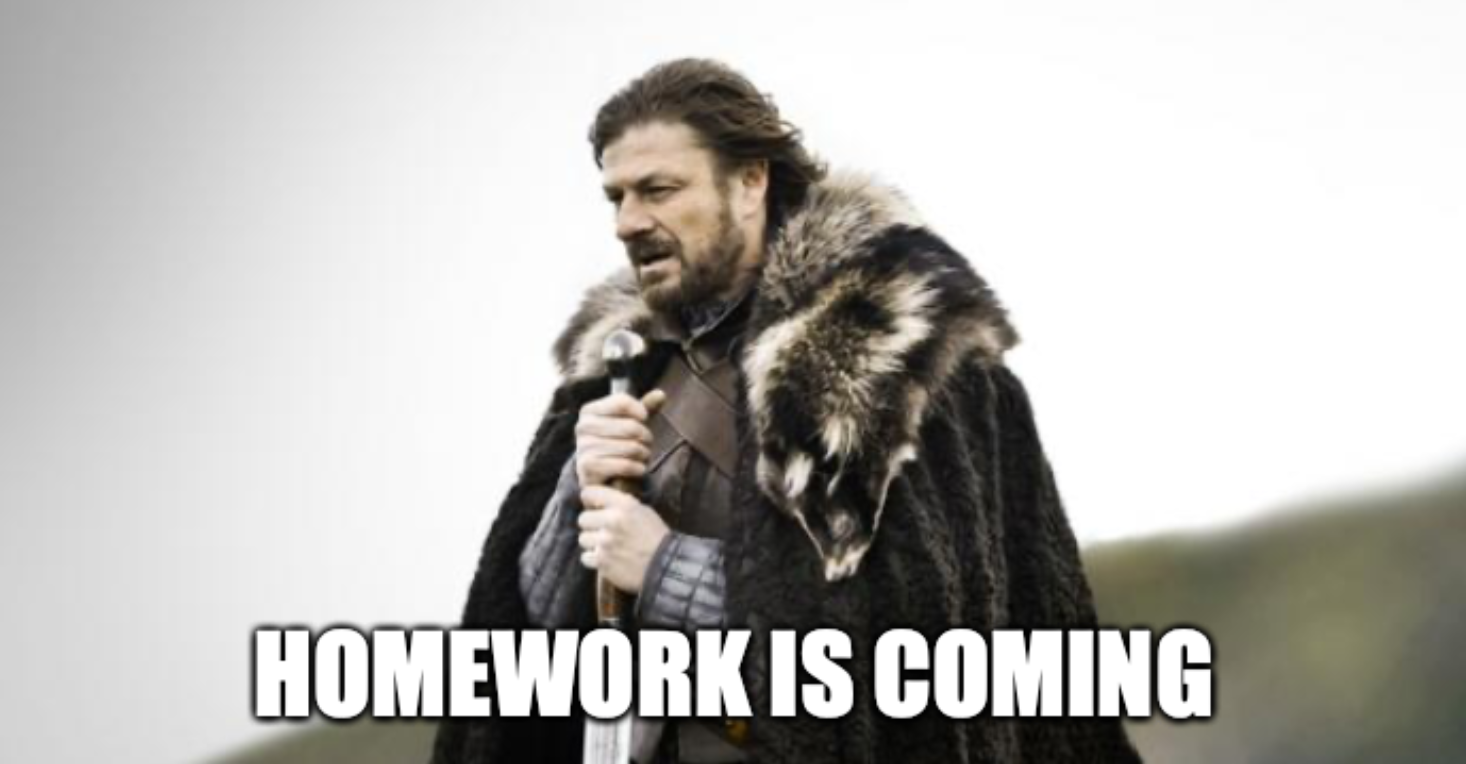


# Instructions for the homework
  > Follow the instructions in the notebook carefully
  


## General instructions
  * Do NOT remove ANYTHING that is already in the notebook.
  * Before you start, show the line number for the code cells:
    * Go to Tools -> Settings -> Editor -> show line numbers
  * Having **EXACTLY TWO** students per group is **MANDATORY**
  * The software must be commented.
  * About this notebook:
    * Create a personal copy to be able to modify it: File > Save a copy in Drive
    * Rename the copied notebook `BDC2024-HW1.ipynb`


## Instructions for **code**:
  * DO NOT add code cells
  * DO NOT remove any code cells
  * Only edit the code cells containing the comment `#YOUR CODE STARTS HERE#`. Within those cells:
    * DO NOT remove ANYTHING that we have written (otherwise specified).
    * Add your code between line `#YOUR CODE STARTS HERE#` and line `#YOUR CODE ENDS HERE#`; **DO NOT REMOVE THESE COMMENTS**
    * The last line in each code cell is #THIS IS LINE \<TOT>#, where \<TOT> is a line number. The notebook is constructed so that \<TOT> matches with the line number in which it is written, but it may of course move as you add your code. **Try to make sure that, when you deliver it, that comment returns to line \<TOT>.** DO NOT CHANGE THE \<TOT> VALUE. Of course, this means that you have a limited number of lines of code that you should try to stay within as closely as possible. On the other hand, if your code is shorter than that, you have to reach that line number with empty lines.

> Ensure that the notebook can be faithfully reproduced by anyone (hint: pseudo random number generation).

> **If you need to set a random seed, set it to `1224`.**

[comment]: <> (#REMOVE_CELL#)


## Instructions for **text**:
* DO NOT add text cells
* DO NOT remove text cells
* DO NOT modify the text cells we have created.
* Only edit text cells starting with the comment ------------YOUR TEXT STARTS HERE------------. Within those cells:
  * Do NOT remove anything we have entered.
  * **Add your own text after the line ------------YOUR TEXT STARTS HERE------------; DO NOT REMOVE THIS TEXT**
  * For each cell, a specific delivery will be given. If you are given a maximum number of sentences to write, both the dot "." and the semicolon ";" will be considered sentence dividers.

[comment]: <> (#REMOVE_CELL#)


## *Evaluation*

The homework will be evaluated based on the following criteria:

1. **Code Quality**: correctness, readability (length, comments, unnecessary repetitions)
2. **Quality of Textual Responses**: correctness, clarity, etc.
3. **Quality of Produced Visualizations** (tables/figures/etc.): correctness, clarity, etc.
4. **Quality**, **quantity** and **diversity** of experiments conducted, **results** achieved, etc. \[if applicable; will be clearly indicated\]
5. **Timely Submission**: late submissions will result in significant point deductions
6. **Plagiarism**: copying code/text from colleagues or online sources will result in significant point deductions \[it will be clearly indicated if borrowing code from other sources is allowed\]

*You are expected to work in a principled way, being aware of what you are doing and why*

[comment]: <> (#REMOVE_CELL#)

## Group composition:

Write down the list of group members. The format should be Last Name, First Name, Student ID. Group members should be sorted alphabetically by surname and placed on different lines.
Example:

Becchetti, Luca, 123456

Siciliano, Federico, 987654

------------YOUR TEXT STARTS HERE------------

Ercoli, Fabio Massimo, 802397

Mai Mihai, Cristian Andrei, 1942925


## Submission (read carefully)

1. This notebook is one of two parts of a Google Classroom assignment, hence it should be delivered using Google Classroom. Your delivery for Homework 1 will thus consist of two files: i) this notebook; ii) a pdf with your answers to the theoretical assignments.
2. Each notebook should be delivered *only once*, by the student whose last name comes first in alphabetical order in your group. So for example, if the group consists of Luca Becchetti and Federico Siciliano, Luca Becchetti (and *he only*) will deliver the homework (Federico Siciliano might well pay attention that he actually does so within the mandatory deadline :-))
3. You can upload multiple files as part of the same assignment in Google Classroom. Please be sure that you only press the Classroom's "hand in" button ("Consegna" in Italian) after you have uploaded the final versions of this notebook and of the pdf containing your answers to the theoretical questions.

<div style="page-break-after: always; visibility: hidden">
\pagebreak
</div>

## Homework 1 (notebook)
The homework Vector Search in all instantiations we have covered in class

# Vector search techniques
Your task is to explore vector search techniques we have presented in class. Use the lab notebook I have presented as a reference and as a tutorial to write this notebook.

Import **ALL** the Python packages that you need for Part 1.

In [1]:
#REMOVE_OUTPUT#
!pip install --upgrade --no-cache-dir gdown
#YOUR CODE STARTS HERE#
!apt install libomp-dev
!pip install faiss-cpu matplotlib
import faiss, timeit, tarfile, os, shutil
import numpy as np
import urllib.request as request
import matplotlib.pyplot as plt
from contextlib import closing
from prettytable import PrettyTable


#YOUR CODE ENDS HERE#
#THIS IS LINE 15#

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libomp-dev is already the newest version (1:14.0-55~exp2).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


## Part 1.1
Your task involves evaluating various indexes based on three key metrics: the **quality** of retrieved results, **memory** consumption, and **time** efficiency.

This part must run within a maximum of **30** minutes. To meet this constraint, approximations can be made (using fewer documents, fewer queries) to *estimate* the required parameters. However, these approximations **must be explicitly indicated** in the code.

The **objectives** are:
1. Find the best option for each of the 3 metrics
2. Find an index that represents a good compromise between the 3 metrics

### 1.1.1
Download the Sift10K dataset from [this site](http://corpus-texmex.irisa.fr/).

In [2]:
#YOUR CODE STARTS HERE#
# first we download the Sift1M dataset

with closing(request.urlopen('ftp://ftp.irisa.fr/local/texmex/corpus/siftsmall.tar.gz')) as r:
    with open('siftsmall.tar.gz', 'wb') as f:
        shutil.copyfileobj(r, f)
tar = tarfile.open('siftsmall.tar.gz', "r:gz")
tar.extractall()
#YOUR CODE ENDS HERE#
#THIS IS LINE 10#

### 1.1.2
If you need to, prepare here helper functions to run your computations.

In [3]:
#YOUR CODE STARTS HERE#
def read_fvecs(fp):
    a = np.fromfile(fp, dtype='int32')
    d = a[0]
    return a.reshape(-1, d + 1)[:, 1:].copy().view('float32')
def get_memory(index):
    faiss.write_index(index, './temp.index')
    file_size = os.path.getsize('./temp.index')
    os.remove('./temp.index')
    return file_size
def score(sub: np.ndarray, base: np.ndarray):
    return np.mean([1 if i in sub else 0 for i in base[0]])

class ExperimentResult:
    def __init__(self, memory: int):
        self.memory = memory
        self.times = []
        self.accuracies = []
        self.kNN = []
    def calculateMeansAndDevs(self):
        self.time_mean = np.array(self.times).mean()
        self.time_std = np.array(self.times).std()
        self.accuracy_mean = np.array(self.accuracies).mean()
        self.accuracy_std = np.array(self.accuracies).std()

def runExperiment(index, queries: np.ndarray, k: int, baselineDocs: np.ndarray) -> ExperimentResult:
    result = ExperimentResult(get_memory(index))
    for i in range(TIMES):
        now = timeit.default_timer()
        _, docs = index.search(queries[i:i+1], k)
        result.times.append(timeit.default_timer() - now)
        if baselineDocs.size == 0:
            result.kNN.append(docs) # in this case I'm defining the baseline
            result.accuracies.append(1)
        else:
            result.accuracies.append(score(docs, baselineDocs[i:i+1]))
    result.calculateMeansAndDevs()
    return result
#YOUR CODE ENDS HERE#
#THIS IS LINE 40#

### 1.1.3
Initiate time calculation for Part 1.

In [4]:
#YOUR CODE STARTS HERE#
start = timeit.default_timer()






#YOUR CODE ENDS HERE#
#THIS IS LINE 10#

### 1.1.4
Prepare the data for vector search.


In [5]:
#YOUR CODE STARTS HERE#
dim = 128
k = 100
data = read_fvecs("./siftsmall/siftsmall_base.fvecs")
queries = read_fvecs('./siftsmall/siftsmall_query.fvecs')
TIMES = 100 # we will test all 100 queries from the dataset
results = {}
SEED = 1224

# try to improve the reproducibility
np.random.seed(SEED)
faiss.rand(SEED)







#YOUR CODE ENDS HERE#
#THIS IS LINE 20#

array([0.7639309 , 0.43778414, 0.02722237, ..., 0.01743807, 0.01725618,
       0.7236713 ], dtype=float32)

Print the size of your variables.

[comment]: <> (#SHOW_CELL#)

In [6]:
#YOUR CODE STARTS HERE#
print("data shape:", data.shape)
print("query shape:", queries.shape)
print("data:")
print(data)
print("queries:")
print(queries)


#YOUR CODE ENDS HERE#
#THIS IS LINE 10#

data shape: (10000, 128)
query shape: (100, 128)
data:
[[ 0. 16. 35. ... 25. 23.  1.]
 [14. 35. 19. ... 11. 21. 33.]
 [ 0.  1.  5. ...  4. 23. 10.]
 ...
 [48.  1.  0. ... 22. 62. 18.]
 [ 0.  0.  0. ...  3.  3. 11.]
 [14.  2.  0. ...  0.  0.  7.]]
queries:
[[ 1.  3. 11. ... 42. 48. 11.]
 [40. 25. 11. ...  3. 19. 13.]
 [28.  4.  3. ...  2. 54. 47.]
 ...
 [14.  8.  0. ... 32. 14. 15.]
 [11. 48. 10. ...  0.  0.  0.]
 [ 4. 10.  5. ... 43.  0.  8.]]


<div style="page-break-after: always; visibility: hidden">
\pagebreak
</div>

### 1.1.5
Prepare your baseline index and get its metrics.


In [7]:
#YOUR CODE STARTS HERE#
index = faiss.IndexFlatL2(dim)
index.add(data)
results["L2 Flat"] = runExperiment(index, queries, k, np.array([]))
baselineDocs = np.array(results["L2 Flat"].kNN).reshape(TIMES, 100)

print("baseline to evaluate accuracy", baselineDocs.shape)
print(baselineDocs)










#YOUR CODE ENDS HERE#
#THIS IS LINE 20#

baseline to evaluate accuracy (100, 100)
[[2176 3752  882 ...  348 3043 3687]
 [2781 9574 2492 ... 3849 2905 4102]
 [2707 9938 2698 ... 1251 8564 8173]
 ...
 [8825 9081 6142 ... 8178 5887 4565]
 [5460 5439 5810 ... 5199 7483 5232]
 [8082 8782 4767 ...   11 2482 3631]]


Why did you choose this index as baseline? Explain your answer in **at most 1 sentence**.

[comment]: <> (#SHOW_CELL#)

------------YOUR TEXT STARTS HERE------------

We decide to use an exact algorithm for search kNN that performs an exhaustive search returning the exact result as a base of the comparison


<div style="page-break-after: always; visibility: hidden">
\pagebreak
</div>

### 1.1.6
Build and test as many indices as possible. For each of them, get the required metrics.

In [8]:
#YOUR CODE STARTS HERE#
nbits = dim*4  # resolution of bucketed vectors
index = faiss.IndexLSH(dim, nbits)
index.add(data)
results["Locality Sensitive Hashing"] = runExperiment(index, queries, k, baselineDocs)
print("LSH times", results["Locality Sensitive Hashing"].times)
print("LSH accuracies", results["Locality Sensitive Hashing"].accuracies)
M = 8  # number of connections each vertex will have
index = faiss.IndexHNSWFlat(dim, M)
index.hnsw.efConstruction = 32  # depth of layers explored during index construction
index.hnsw.efSearch = 32  # depth of layers explored during search
index.add(data)
results["Hierarchical Navigable Small World Graphs"] = runExperiment(index, queries, k, baselineDocs)
print("HNSWG times", results["Hierarchical Navigable Small World Graphs"].times)
print("HNSWG accuracies", results["Hierarchical Navigable Small World Graphs"].accuracies)

nlist = 128  # number of cells/clusters to partition data into
quantizer = faiss.IndexFlatL2(dim)  # how the vectors will be stored/compared
index = faiss.IndexIVFFlat(quantizer, dim, nlist)
index.nprobe = 8  # set how many of nearest cells to search
index.cp.seed = SEED
index.train(data)
index.add(data)
results["Inverted File"] = runExperiment(index, queries, k, baselineDocs)
print("IVF times", results["Inverted File"].times)
print("IVF accuracies", results["Inverted File"].accuracies)

m = 8
nbits = 8  # number of bits per subquantizer, k* = 2**nbits
index = faiss.IndexPQ(dim, m, nbits)
index.pq.seed = SEED
index.train(data)
index.add(data)
results["Product Quantization"] = runExperiment(index, queries, k, baselineDocs)
print("PQ times", results["Product Quantization"].times)
print("PQ accuracies", results["Product Quantization"].accuracies)

vecs = faiss.IndexFlatL2(dim)
nlist = 256  # how many Voronoi cells (must be >= k* which is 2**nbits)
index = faiss.IndexIVFPQ(vecs, dim, nlist, m, nbits)
index.nprobe = 48
index.cp.seed = SEED
index.pq.cp.seed = SEED
index.train(data)
index.add(data)
results["Inverted File Product Quantization"] = runExperiment(index, queries, k, baselineDocs)
print("IVFPQ times", results["Inverted File Product Quantization"].times)
print("IVFPQ accuracies", results["Inverted File Product Quantization"].accuracies)
#YOUR CODE ENDS HERE#
#THIS IS LINE 50#

LSH times [0.024077224999984992, 0.0003786539999737215, 0.00024883200001113437, 0.0002233839999803422, 0.00034314699996684794, 0.0002172369999584589, 0.00020159199999625343, 0.00020992000003161593, 0.0001971080000089387, 0.0002226419999828977, 0.0001934570000230451, 0.00020526499997686187, 0.00019402200001650272, 0.00019752600002220788, 0.00019128599996065532, 0.00021280300001080832, 0.00019292199999654258, 0.00020578999999543157, 0.00019488399999545436, 0.00019032099999094498, 0.0002134270000055949, 0.00018683899997995468, 0.00019663899996658074, 0.0001971450000155528, 0.0001882519999867327, 0.0001912390000029518, 0.00023202399995625456, 0.0002043130000402016, 0.008158347000005506, 0.00033304000004363843, 0.00037138199996888943, 0.0031446219999793357, 0.00034299800000781033, 0.0028928039999982502, 0.0002902759999869886, 0.00025258599998778664, 0.00020679499999687323, 0.00022274299999480718, 0.006696357999999236, 0.0003475329999673704, 0.00032280600004241933, 0.0002442789999577144, 0.0

### 1.1.7
Stop time calculation for Part 1.

In [9]:
#YOUR CODE STARTS HERE#
total_time = timeit.default_timer() - start






#YOUR CODE ENDS HERE#
#THIS IS LINE 10#

Print the time.

[comment]: <> (#SHOW_CELL#)

In [10]:
#YOUR CODE STARTS HERE#
print(total_time)






#YOUR CODE ENDS HERE#
#THIS IS LINE 10#

7.935896033000006


<div style="page-break-after: always; visibility: hidden">
\pagebreak
</div>

### 1.1.8
Produce a table with your results. If you have approximated your results, you need to write it explicitly and **possibly** do something to show this (e.g. standard deviation? confidence intervals?).

In [11]:
#YOUR CODE STARTS HERE#
resultTable = PrettyTable(["Algorithm", "Index size", "Query time avg.",
                           "Query time std. dev.", "Accuracy avg.", "Accuracy std. dev."])
for key, experiment in results.items():
  resultTable.add_row([key, experiment.memory, experiment.time_mean, experiment.time_std,
                       experiment.accuracy_mean, experiment.accuracy_std])

print(resultTable)




















#YOUR CODE ENDS HERE#
#THIS IS LINE 30#

+-------------------------------------------+------------+------------------------+------------------------+--------------------+---------------------+
|                 Algorithm                 | Index size |    Query time avg.     |  Query time std. dev.  |   Accuracy avg.    |  Accuracy std. dev. |
+-------------------------------------------+------------+------------------------+------------------------+--------------------+---------------------+
|                  L2 Flat                  |  5120045   | 0.0008380962099988665  | 0.0012606452393716019  |        1.0         |         0.0         |
|         Locality Sensitive Hashing        |   902237   | 0.0013157839699965734  | 0.0028813749514673987  | 0.6748000000000002 | 0.09729830419899414 |
| Hierarchical Navigable Small World Graphs |  5925650   | 0.0001158811700008755  | 2.952649994096205e-05  |       0.764        | 0.07197221686178633 |
|               Inverted File               |  5266699   | 0.00014737021000144068 | 0.00

If focusing solely on one metric, which index would you select? Why do you think that specific index got the best result for that metric? Explain your answer in **at most 3 sentences (1 for each metric)**.

[comment]: <> (#SHOW_CELL#)

------------YOUR TEXT STARTS HERE------------


The product quantization seems to provide the best result in terms of index size.
The inverted file seems to be the fastest, both the mean and the standard deviation are the best result.
The inverted file also provides the best accuracy.

<div style="page-break-after: always; visibility: hidden">
\pagebreak
</div>

If considering all metrics, which index would you choose and why? Explain your answer in **at most 2 sentences**.

[comment]: <> (#SHOW_CELL#)

------------YOUR TEXT STARTS HERE------------

IVF and HNSWG produce a too large index, even greater than the L2. The LSH has not a great accuracy, it probably suffers the curse of dimensionality. The PQ seems to be too slow. We would choose the IVFPQ.

<div style="page-break-after: always; visibility: hidden">
\pagebreak
</div>

### 1.1.9
Visualize your results. If you have approximated your results, you need to write it explicitly and **possibly** do something to show this (e.g. standard deviation? confidence intervals?).

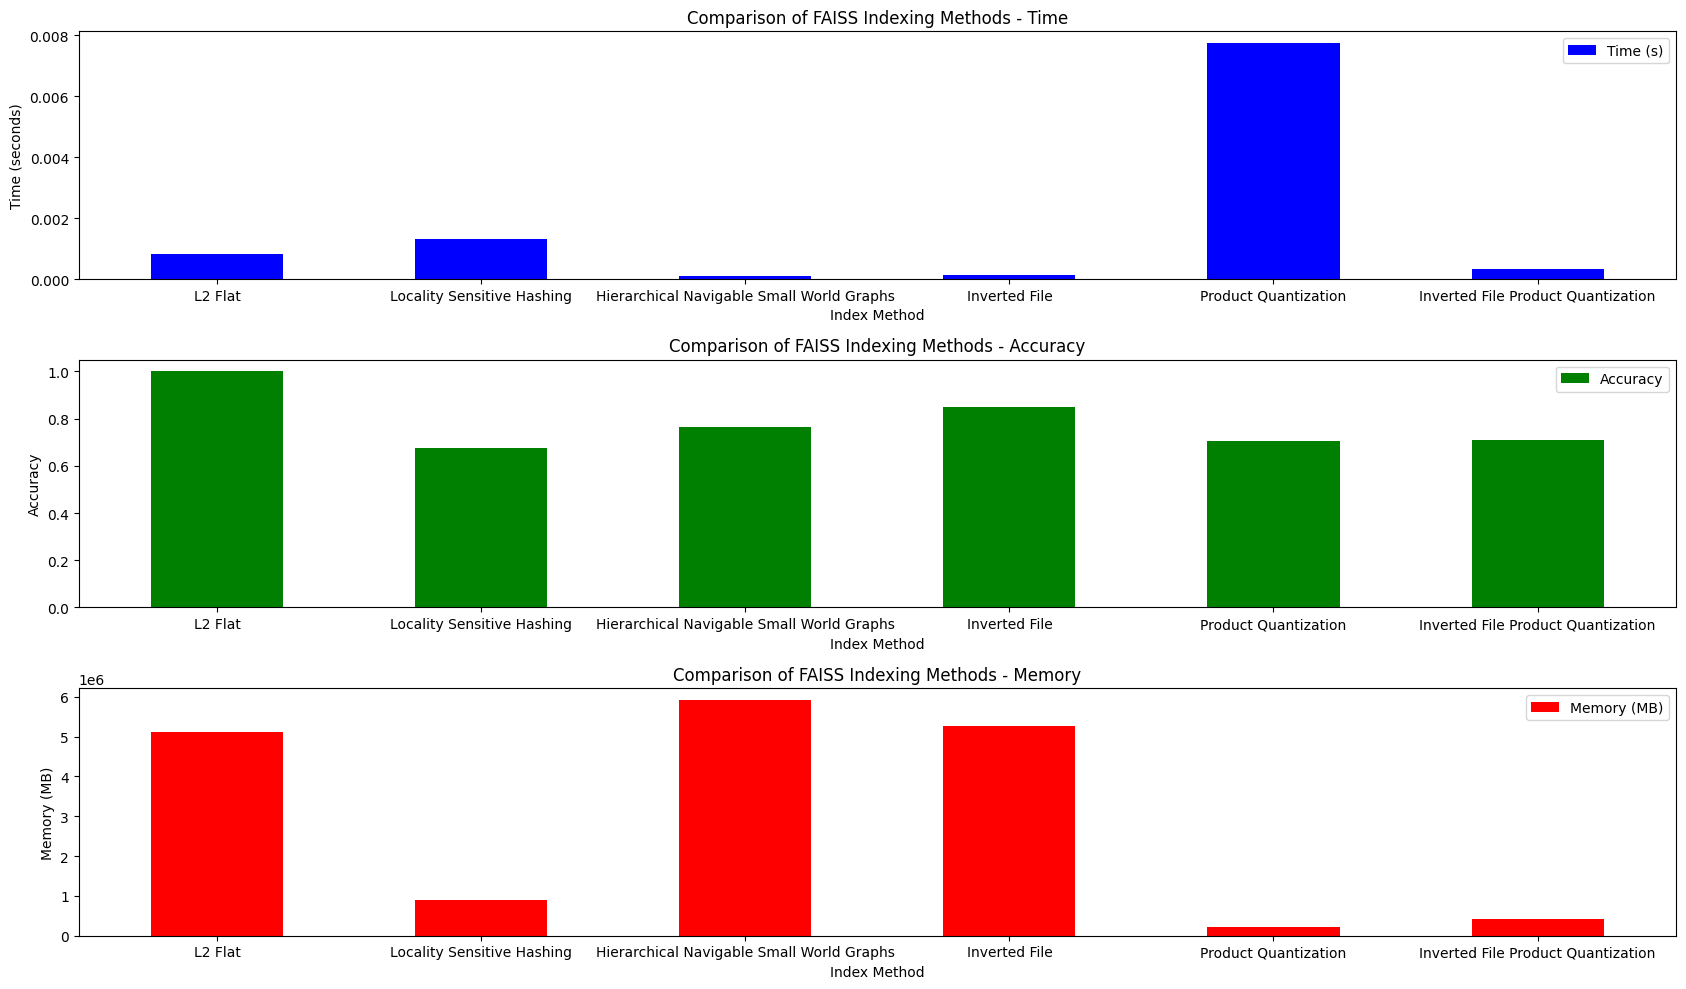

In [12]:
#YOUR CODE STARTS HERE#
# Set up the figure and axes
# Extracting data
methods = list(results.keys())
time_data = [results[method].time_mean for method in methods]
accuracy_data = [results[method].accuracy_mean for method in methods]
memory_data = [results[method].memory for method in methods]

# Bar width and index
bar_width = 0.5
index = np.arange(len(methods))

# Create a figure and set of subplots for different metrics
fig, axs = plt.subplots(3, 1, figsize=(17, 10))

# Time graph
axs[0].bar(index, time_data, bar_width, color='b', label='Time (s)')
axs[0].set_title('Comparison of FAISS Indexing Methods - Time')
axs[0].set_xlabel('Index Method')
axs[0].set_ylabel('Time (seconds)')
axs[0].set_xticks(index)
axs[0].set_xticklabels(methods)
axs[0].legend()

# Accuracy graph
axs[1].bar(index, accuracy_data, bar_width, color='g', label='Accuracy')
axs[1].set_title('Comparison of FAISS Indexing Methods - Accuracy')
axs[1].set_xlabel('Index Method')
axs[1].set_ylabel('Accuracy')
axs[1].set_xticks(index)
axs[1].set_xticklabels(methods)
axs[1].legend()

# Memory graph
axs[2].bar(index, memory_data, bar_width, color='r', label='Memory (MB)')
axs[2].set_title('Comparison of FAISS Indexing Methods - Memory')
axs[2].set_xlabel('Index Method')
axs[2].set_ylabel('Memory (MB)')
axs[2].set_xticks(index)
axs[2].set_xticklabels(methods)
axs[2].legend()

# Display the plot
plt.tight_layout()
plt.show()



#YOUR CODE ENDS HERE#
#THIS IS LINE 50#

Comment your results in **at most 3 sentences**, *possibly* providing new insights and with minimal overlap with previous answers.

[comment]: <> (#SHOW_CELL#)

------------YOUR TEXT STARTS HERE------------

All the results we got are very dependent on the size of the dataset and on the setting with use for creating the indexes. Looking at the graph, even the L2 flat seems to work nicely. We can confirm our preference for the IVFPQ.

<div style="page-break-after: always; visibility: hidden">
\pagebreak
</div>